# Summary

Historical data in this file is from the period 2020-12-20 to 2025-08-31.

Strategies with strong results:
  - Strategy 1: Correlation to one asset based on returns, one period behind, train up to 2024-01-01, correlation for all assets, fixed correlation in test period to calculate weights
  - Strategy 2: Like strategy 1 except with correlation based on prices
  - Strategy 16: Strategy 3 with rank-thresholding -- top and bottom 5%, top and bottom 10%, top and bottom 5% only traded daily (especially good for not having large drawdown)

All strategies:
  - ~Strategy 1: Correlation to one asset based on returns, one period behind, train up to 2024-01-01, correlation for all assets, fixed correlation in test period to calculate weights~
  - ~Strategy 2: Like strategy 1 except with correlation based on prices~
  - ~Strategy 3: Rolling correlation of returns based on last N periods, dynamically selected at each time step~
  - Strategy 4: Rolling correlation of prices based on last N periods, dynamically selected at each time step
  - Strategy 5: Correlation to one asset based on returns, one period behind, trained up to 2024-01-01, correlation for only assets with correlation above threshold x
  - Strategy 6: Correlation to one asset based on prices, one period behind, trained up to 2024-01-01, correlation for only assets with correlation above threshold x
  - Strategy 7: Correlation to one asset based on returns, one period behind, train up to 2024-01-01, correlation for all assets, dynamic trailing correlation in test period to calculate weights
  - Strategy 8: Same as strategy 1 but winsorized
  - Strategy 9: Same as strategy 1 but truncated
  - Strategy 10: Same as strategy 1 but rank-threshold
  - Strategy 11: Same as strategy 1 but inverse CDF: rank, inverse CDF, then demean-normalize
  - Strategy 12: Strategy 1 with exponential decay
  - Strategy 13: Strategy 1 with average over running period
  - ~Strategy 14: Strategy 3 with winsorization~
  - ~Strategy 15: Strategy 3 with truncation~
  - ~Strategy 16: Strategy 3 with rank-thresholding~

# Imports

In [1]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd
import numpy as np

from ipynb.fs.full.utility_functions import (
    get_rank_demeaned_normalized_signal,
    get_gross_returns_and_net_returns,
    calculate_correlation_directly,
    calculate_covariance_directly,
    get_decorrelated_returns,
    get_strategy_stats,
    get_winsorized_signal,
    get_truncated_signal,
    get_rank_thresholded_signal,
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Get Historical Data For Cryptocurrencies

In [2]:
# The universe is based on this snapshot from December 20, 2020: https://coinmarketcap.com/historical/20201220/

univ = [
    "BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT", "DOTUSDT", "MATICUSDT", "LTCUSDT", "BCHUSDT",
    "LINKUSDT", "XLMUSDT", "USDCUSDT", "EOSUSDT", "TRXUSDT", "XTZUSDT", "FILUSDT", "NEOUSDT", "DAIUSDT",
    "DASHUSDT", "VETUSDT", "ATOMUSDT", "AAVEUSDT", "UNIUSDT", "GRTUSDT", "THETAUSDT", "IOTAUSDT", "BUSDUSDT",
    "ZECUSDT", "YFIUSDT", "ETCUSDT", "WAVESUSDT", "COMPUSDT", "SNXUSDT", "DOGEUSDT", "MKRUSDT", "ZILUSDT",
    "SUSHIUSDT", "KSMUSDT", "OMGUSDT", "ONTUSDT", "ALGOUSDT", "EGLDUSDT", "BATUSDT", "DGBUSDT", "ZRXUSDT",
    "TUSDUSDT", "QTUMUSDT", "ICXUSDT", "AVAXUSDT", "RENUSDT", "HBARUSDT", "NEARUSDT", "LRCUSDT", "CELOUSDT",
    "KNCUSDT", "LSKUSDT", "OCEANUSDT", "QNTUSDT", "USTUSDT", "BANDUSDT", "MANAUSDT", "ENJUSDT", "ANTUSDT",
    "BNTUSDT", "ZENUSDT", "NMRUSDT", "RVNUSDT", "IOSTUSDT", "OXTUSDT", "CRVUSDT", "MATICUSDT", "HNTUSDT",
    "BALUSDT", "CHZUSDT"
]

should_download_stock_data = False

In [3]:
client = bnb_client(tld='US')

def get_binance_px(symbol, freq, start_ts = '2020-12-20'):
    data = client.get_historical_klines(symbol, freq, start_ts)
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume',
               'num_trades', 'taker_base_volume', 'taker_quote_volume', 'ignore']
    data = pd.DataFrame(data, columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 


if should_download_stock_data:
    freq = '4h'
    px = {}
    for x in univ:
        print(f"Downloading data for symbol {x}")
        data = get_binance_px(x, freq)
        px[x] = data.set_index('open_time')['close']

    px = pd.DataFrame(px).astype(float)
    px.to_csv('./class_project_input_prices.csv')
else:
    px = pd.read_csv('./class_project_input_prices.csv')
    date_format = "%Y-%m-%d %H:%M:%S"
    px['open_time'] = px['open_time'].apply(lambda t:  datetime.strptime(t, date_format))
    px.set_index('open_time', inplace=True)

# Data up to 2025-08-31 08:00:00
px

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,LTCUSDT,BCHUSDT,LINKUSDT,...,BNTUSDT,ZENUSDT,NMRUSDT,RVNUSDT,IOSTUSDT,OXTUSDT,CRVUSDT,HNTUSDT,BALUSDT,CHZUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2020-12-20 00:00:00,23353.97,646.62,0.16284,32.9681,0.56944,NaN,NaN,117.34,313.46,NaN,...,NaN,12.056,NaN,NaN,NaN,0.2492,NaN,1.41095,NaN,NaN
2020-12-20 04:00:00,23604.24,655.23,0.16638,33.6559,0.57916,NaN,NaN,121.30,340.00,NaN,...,NaN,12.107,NaN,NaN,NaN,0.2477,NaN,1.43156,NaN,NaN
2020-12-20 08:00:00,23549.50,652.88,0.16463,34.8228,0.57948,NaN,NaN,118.09,349.70,NaN,...,NaN,12.237,NaN,NaN,NaN,0.2477,NaN,1.44273,NaN,NaN
2020-12-20 12:00:00,23880.85,653.24,0.16542,35.0120,0.57798,NaN,NaN,119.10,361.21,NaN,...,NaN,12.074,NaN,NaN,NaN,0.2533,NaN,1.47130,NaN,NaN
2020-12-20 16:00:00,23932.71,649.82,0.16502,34.7042,0.57306,NaN,NaN,116.60,357.09,NaN,...,NaN,12.008,NaN,NaN,NaN,0.2503,NaN,1.43083,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-30 16:00:00,108921.64,4352.10,0.81950,856.7600,2.80720,3.816,NaN,110.23,542.00,23.36,...,0.725,7.240,16.62,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-30 20:00:00,108569.75,4374.56,0.82170,862.6200,2.81940,3.773,NaN,110.77,552.90,23.47,...,0.725,7.240,15.16,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-31 00:00:00,109155.73,4486.79,0.83590,863.4900,2.85180,3.867,NaN,111.67,551.30,23.90,...,0.764,7.240,15.21,0.01353,0.00342,0.0535,0.7936,NaN,NaN,0.04045


# Utility Functions

In [11]:
bitcoin_benchmark_returns = px['BTCUSDT'] / px['BTCUSDT'].shift() - 1

# time_point must be in the index of df
def get_train_test_data(df, time_point):
    train_data = df.loc[:time_point].iloc[:-1]
    test_data = df.loc[time_point:]
    return train_data, test_data


def get_coins_to_top_corr_coins(
    coin_data, compared_coin_data, remove_nan_columns = False, look_back_len_for_non_null = 10):
    
    if len(coin_data) < look_back_len_for_non_null:
        raise ValueError(f"Length of input {len(coin_data)} is less than the look-back length: {look_back_len_for_non_null}")
    
    coins_to_top_corr_coins = dict()
    
    for col in coin_data.columns:
        if remove_nan_columns and coin_data[col].isna().any():
            coins_to_top_corr_coins[col] = np.nan
            continue
        
        corr_with_coin = compared_coin_data.apply(lambda coin_col: calculate_correlation_directly(coin_col, coin_data[col]))
        
        distinct_corr_with_coin = corr_with_coin[corr_with_coin.index != col]
        
        matching_columns = distinct_corr_with_coin.index[
            coin_data[distinct_corr_with_coin.index].iloc[(-look_back_len_for_non_null):].notna().any()
        ]
        non_na_distinct_corr_with_coin = distinct_corr_with_coin[matching_columns]

        if len(non_na_distinct_corr_with_coin) == 0:
            coins_to_top_corr_coins[col] = np.nan
        else:
            coins_to_top_corr_coins[col] = non_na_distinct_corr_with_coin.index[
                non_na_distinct_corr_with_coin.abs().argmax()
            ]
    return pd.Series(coins_to_top_corr_coins)


def get_coins_to_look_back_reg_params(output_data, input_data, coins_to_top_corr_coins):
    coins_to_look_back_reg_params = dict()
    
    for coin in output_data.columns:
        corr_coin = coins_to_top_corr_coins[coin]
        
        if str(corr_coin) == 'nan':
            continue

        beta = calculate_covariance_directly(
            output_data[coin], input_data[corr_coin]) / input_data[corr_coin].var()

        val_input = input_data[corr_coin].notna()
        val_output = output_data[coin].notna()

        inputs = input_data[corr_coin][val_input & val_output]
        outputs = output_data[coin][val_input & val_output]

        alpha = outputs.mean() - beta * inputs.mean()
        coins_to_look_back_reg_params[coin] = {"alpha": alpha, "beta": beta}
    
    return coins_to_look_back_reg_params

# Strategy 1: Correlation to one asset based on returns, one period behind, train up to 2024-01-01, correlation for all assets, fixed correlation in test period to calculate weights

## Calculate Signal

In [5]:
ret = px / px.shift() - 1
t = datetime(2024, 1, 1, 0, 0)
ret_train_data, ret_test_data = get_train_test_data(ret, t)

coins_to_top_corr_coins_by_ret = get_coins_to_top_corr_coins(ret_train_data, ret_train_data.shift())

coin_rets_to_look_back_reg_params = get_coins_to_look_back_reg_params(
    ret_train_data, ret_train_data.shift(), coins_to_top_corr_coins_by_ret)

In [6]:
raw_reg_signal = pd.DataFrame(index=ret_test_data.index)
raw_reg_signal.index.names = ['Periods']

for coin in ret_test_data.columns:
    reg_ret = ret_test_data[coins_to_top_corr_coins_by_ret[coin]].shift() * coin_rets_to_look_back_reg_params[coin]['beta']
    reg_ret = reg_ret + coin_rets_to_look_back_reg_params[coin]['alpha']
    
    raw_reg_signal[coin] = -1 * (ret_test_data[coin] - reg_ret)

normalized_signal = get_rank_demeaned_normalized_signal(raw_reg_signal)

## Calculate Returns

In [7]:
test_px = px.loc[normalized_signal.index]
gross_returns, net_returns = get_gross_returns_and_net_returns(normalized_signal, test_px)

<Axes: title={'center': 'Strat 1, Cumulative Gross Returns'}, xlabel='Periods'>

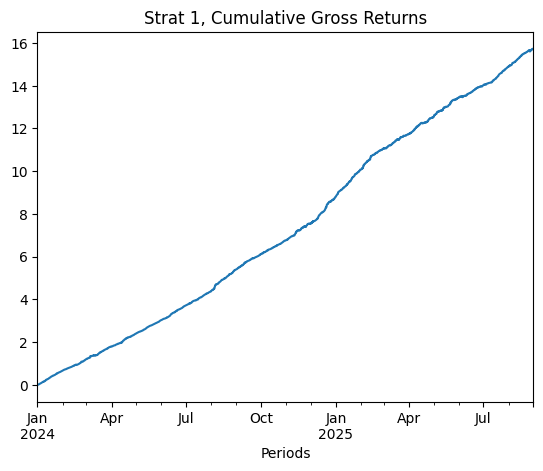

In [8]:
gross_returns.cumsum().plot(title="Strat 1, Cumulative Gross Returns")

In [9]:
pd.Series(get_strategy_stats(net_returns, 4, test_px), name="Strat 1").to_frame()

,Strat 1
avg returns,3.142919
decorrelated avg returns,3.126304
volatility,0.300609
sharpe ratio,10.455168
decorrelated sharpe ratio,10.407555
max drawdown,-2.171735
max drawdown duration,20.500000
alpha_BTC,0.001428
beta_BTC,0.025543


<Axes: title={'center': 'Strat 1, Benchmark, De-Correlated Strat 1, Cumulative Net Returns'}, xlabel='Periods'>

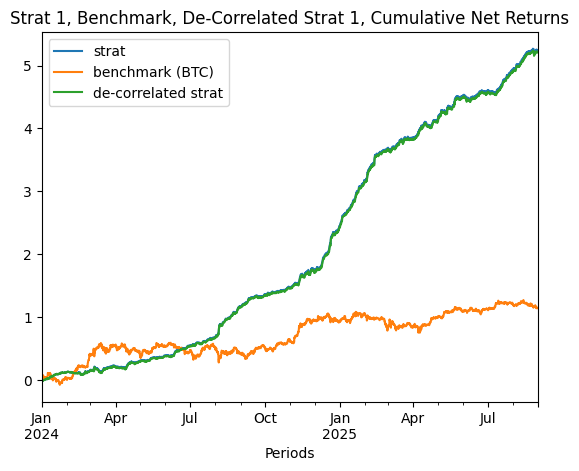

In [10]:
test_btc_rets = test_px['BTCUSDT'] / test_px['BTCUSDT'].shift() - 1

df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": test_btc_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, test_btc_rets)
})

df.cumsum().plot(title = "Strat 1, Benchmark, De-Correlated Strat 1, Cumulative Net Returns")

The strategy and the de-correlated strategy are effectively the same and the path of the green line covers that of the blue one. This strategy is sufficiently de-correlated from the movement of BTC to be essentially unaffected by it.

# Strategy 2: Like strategy 1 except with correlation based on prices

## Calculate Signal

In [11]:
t = datetime(2024, 1, 1, 0, 0)
px_train_data, px_test_data = get_train_test_data(px, t)

coins_to_top_corr_coins_by_px = get_coins_to_top_corr_coins(px_train_data, px_train_data.shift())

coin_px_to_look_back_reg_params = get_coins_to_look_back_reg_params(
    px_train_data, px_train_data.shift(), coins_to_top_corr_coins_by_px)

In [12]:
raw_reg_signal = pd.DataFrame(index=px_test_data.index)
raw_reg_signal.index.names = ['Periods']

for coin in px_test_data.columns:
    reg_px = px_test_data[coins_to_top_corr_coins_by_px[coin]].shift() * coin_px_to_look_back_reg_params[coin]['beta']
    reg_px = reg_px + coin_px_to_look_back_reg_params[coin]['alpha']
    
    raw_reg_signal[coin] = -1 * (px_test_data[coin] - reg_px)

normalized_signal = get_rank_demeaned_normalized_signal(raw_reg_signal)

## Calculate Returns

In [13]:
test_px = px.loc[normalized_signal.index]
gross_returns, net_returns = get_gross_returns_and_net_returns(normalized_signal, test_px)

<Axes: title={'center': 'Strat 2, Cumulative Gross Returns'}, xlabel='Periods'>

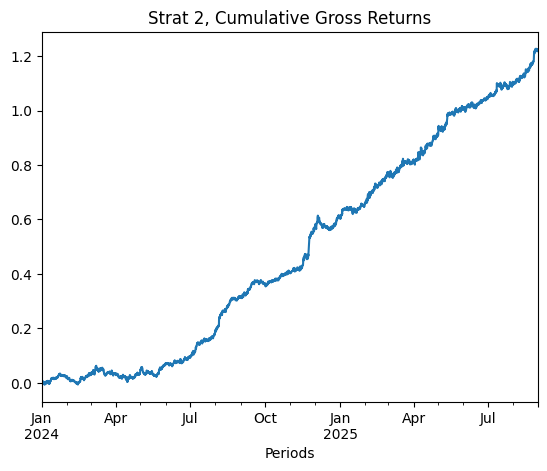

In [14]:
gross_returns.cumsum().plot(title="Strat 2, Cumulative Gross Returns")

In [15]:
pd.Series(get_strategy_stats(net_returns, 4, test_px), name="Strat 2").to_frame()

,Strat 2
avg returns,0.518631
decorrelated avg returns,0.563801
volatility,0.164364
sharpe ratio,3.155378
decorrelated sharpe ratio,3.497602
max drawdown,-13.975127
max drawdown duration,167.833333
alpha_BTC,0.000258
beta_BTC,-0.065709


<Axes: title={'center': 'Strat 2, Benchmark, De-Correlated Strat 2, Cumulative Net Returns'}, xlabel='Periods'>

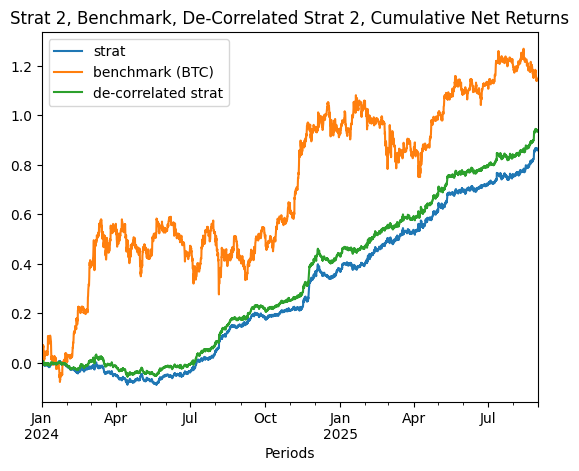

In [16]:
df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": test_btc_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, test_btc_rets)
})

df.cumsum().plot(title = "Strat 2, Benchmark, De-Correlated Strat 2, Cumulative Net Returns")

# Strategy 3: Rolling correlation of returns based on last N periods, dynamically selected at each time step

## Calculate Signal

In [20]:
ret = px / px.shift() - 1

should_calculate_best_corr = False

if should_calculate_best_corr:
    time_to_top_ret_corr_coins_dict = dict()

    window_len = 20
    all_indices = list(ret.index)

    for index in range(window_len, len(ret)):
        time_to_top_ret_corr_coins_dict[all_indices[index]] = get_coins_to_top_corr_coins(
            ret.iloc[(index-window_len):index],
            ret.shift().iloc[(index-window_len):index],
            remove_nan_columns = True,
            look_back_len_for_non_null = 10
        )
        print(f"{index - window_len + 1} / {len(ret) - window_len + 1}")

    time_to_top_ret_corr_coins_df = pd.DataFrame(time_to_top_ret_corr_coins_dict).T
    time_to_top_ret_corr_coins_df.to_csv('./rolling_ret_corr_window_20.csv')
else:
    time_to_top_ret_corr_coins_df = pd.read_csv('./rolling_ret_corr_window_20.csv', index_col=0)

/var/folders/46/nmm5hcbx71d6nqy2066wsyjc0000gn/T/ipykernel_1442/4182386881.py:23: DtypeWarning: Columns (14,27,31,39,46,59,63,71) have mixed types. Specify dtype option on import or set low_memory=False.
  time_to_top_ret_corr_coins_df = pd.read_csv('./rolling_ret_corr_window_20.csv', index_col=0)


In [21]:
should_calculate_signal = False

if should_calculate_signal:
    dates_to_signals = dict()

    for index in range(window_len, len(ret)):
        time_index = ret.index[index]
        coins_to_reg_params = get_coins_to_look_back_reg_params_10_11_2025(
            ret.iloc[(index-window_len):index],
            ret.shift().iloc[(index-window_len):index],
            time_to_top_ret_corr_coins_df.loc[time_index])

        signal_vals = dict()
        for col in ret.columns:
            if col in coins_to_reg_params:
                params = coins_to_reg_params[col]
                corr_coin = time_to_top_ret_corr_coins_df.loc[time_index][col]
                predicted_ret = ret.shift().iloc[index][corr_coin] * params["beta"] + params["alpha"]
                signal = (-1) * (ret.iloc[index][col] - predicted_ret)
                signal_vals[col] = signal
            else:
                signal_vals[col] = np.nan

        dates_to_signals[time_index] = pd.Series(signal_vals)
        print(f"{index - window_len + 1} / {len(ret) - window_len}")

    raw_signal = pd.DataFrame(dates_to_signals).T
else:
    raw_signal = pd.read_csv('./rolling_corr_signal_window_20.csv', index_col = 0)
    raw_signal.index = raw_signal.index.map(lambda t: datetime.strptime(t, "%Y-%m-%d %H:%M:%S"))

In [22]:
transformed_signal = get_rank_demeaned_normalized_signal(raw_signal)

# Prepend nan data for first 20 periods not included
data_to_prepend = dict()

for index in px[px.index < transformed_signal.index[0]].index:
    data_to_prepend[index] = pd.Series(index=px.columns)

transformed_signal = pd.concat([pd.DataFrame(data_to_prepend).T, transformed_signal])

## Trade Every 4 Hours

<Axes: title={'center': 'Strat 3, Trade Every 4 Hours, Gross Cumulative Returns'}>

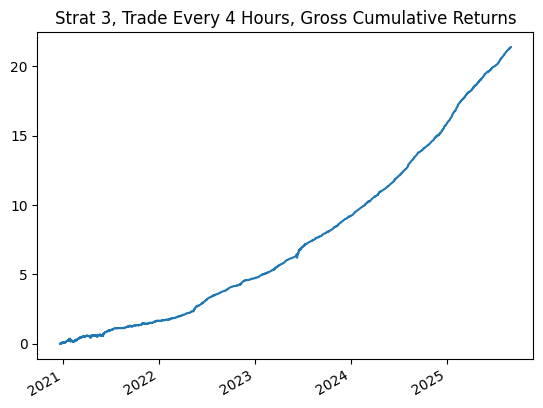

In [23]:
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
gross_returns.cumsum().plot(title="Strat 3, Trade Every 4 Hours, Gross Cumulative Returns")

In [24]:
pd.Series(get_strategy_stats(net_returns, 4, px), name="Strat 3, Trade Every 4 Hours").to_frame()

,"Strat 3, Trade Every 4 Hours"
avg returns,-1.423069
decorrelated avg returns,-1.430067
volatility,0.271947
sharpe ratio,-5.232887
decorrelated sharpe ratio,-5.260728
max drawdown,-716.590676
max drawdown duration,1706.833333
alpha_BTC,-0.000653
beta_BTC,0.013418


<Axes: title={'center': 'Strat 3, Trade Every 4 Hours, \nBenchmark, De-Correlated Strat 3, Cumulative Net Returns'}>

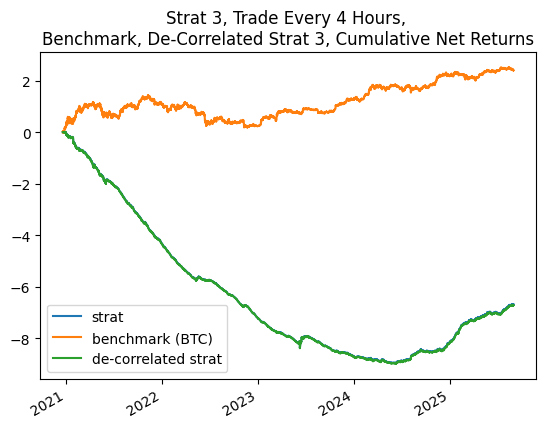

In [25]:
btc_rets = px['BTCUSDT'] / px['BTCUSDT'].shift() - 1

df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": btc_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, btc_rets)
})

df.cumsum().plot(title = "Strat 3, Trade Every 4 Hours, \nBenchmark, De-Correlated Strat 3, Cumulative Net Returns")

## Trade Every 8 Hours

<Axes: title={'center': 'Strat 3, Trade Every 8 Hours, Gross Cumulative Returns'}>

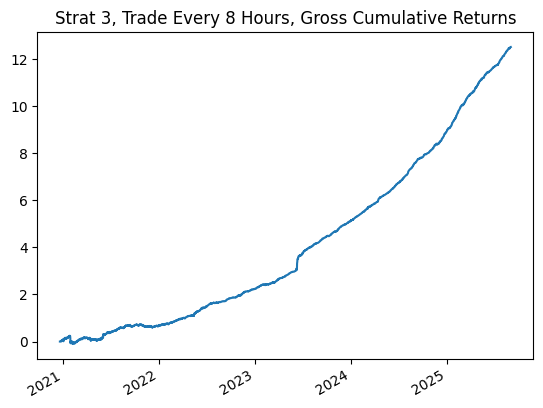

In [26]:
transformed_signal_8h = transformed_signal.loc[transformed_signal.index.hour % 8 == 0]
px_8h = px[px.index.hour % 8 == 0]

gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal_8h, px_8h)
gross_returns.cumsum().plot(title="Strat 3, Trade Every 8 Hours, Gross Cumulative Returns")

In [27]:
pd.Series(get_strategy_stats(net_returns, 8, px_8h), name="Strat 3, Trade Every 8 Hours").to_frame()

,"Strat 3, Trade Every 8 Hours"
avg returns,-0.218531
decorrelated avg returns,-0.225611
volatility,0.278409
sharpe ratio,-0.784927
decorrelated sharpe ratio,-0.810641
max drawdown,-119.942655
max drawdown duration,1697.000000
alpha_BTC,-0.000206
beta_BTC,0.013861


<Axes: title={'center': 'Strat 3, Trade Every 8 Hours, \nBenchmark, De-Correlated Strat 3, Cumulative Net Returns'}>

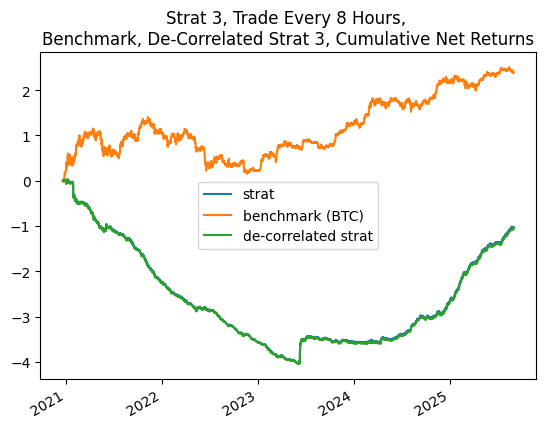

In [28]:
btc_rets = px_8h['BTCUSDT'] / px_8h['BTCUSDT'].shift() - 1

df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": btc_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, btc_rets)
})

df.cumsum().plot(title = "Strat 3, Trade Every 8 Hours, \nBenchmark, De-Correlated Strat 3, Cumulative Net Returns")

## Trade Every 12 Hours

<Axes: title={'center': 'Strat 3, Trade Every 12 Hours, Gross Cumulative Returns'}>

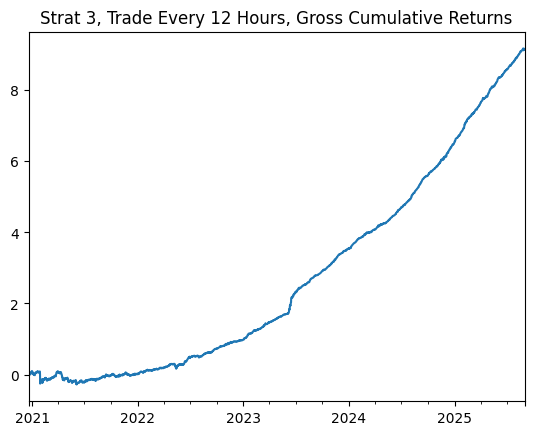

In [29]:
transformed_signal_12h = transformed_signal.loc[transformed_signal.index.hour % 12 == 0]
px_12h = px[px.index.hour % 12 == 0]

gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal_12h, px_12h)
gross_returns.cumsum().plot(title="Strat 3, Trade Every 12 Hours, Gross Cumulative Returns")

In [30]:
pd.Series(get_strategy_stats(net_returns, 12, px_12h), name="Strat 3, Trade Every 12 Hours").to_frame()

,"Strat 3, Trade Every 12 Hours"
avg returns,0.038735
decorrelated avg returns,0.038136
volatility,0.262997
sharpe ratio,0.147284
decorrelated sharpe ratio,0.144986
max drawdown,-52.429257
max drawdown duration,1671.000000
alpha_BTC,0.000052
beta_BTC,0.001215


<Axes: title={'center': 'Strat 3, Trade Every 12 Hours, \nBenchmark, De-Correlated Strat 3, Cumulative Net Returns'}>

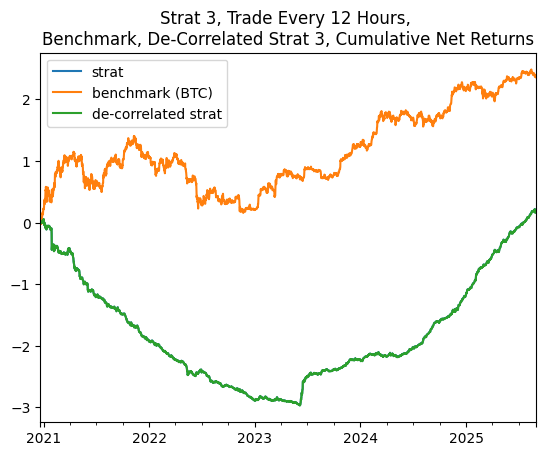

In [31]:
btc_rets = px_12h['BTCUSDT'] / px_12h['BTCUSDT'].shift() - 1

df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": btc_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, btc_rets)
})

df.cumsum().plot(title = "Strat 3, Trade Every 12 Hours, \nBenchmark, De-Correlated Strat 3, Cumulative Net Returns")

## Trade Every 24 Hours

<Axes: title={'center': 'Strat 3, Trade Every 24 Hours, Gross Cumulative Returns'}>

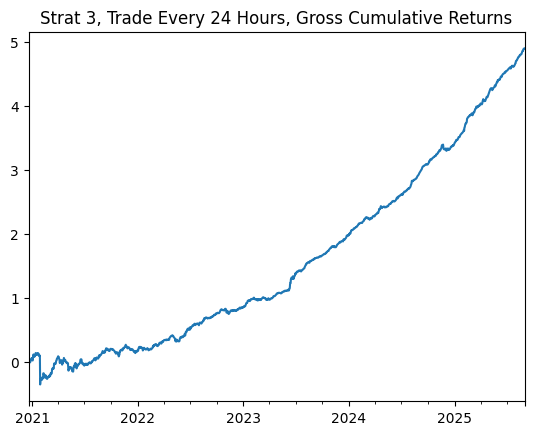

In [32]:
transformed_signal_24h = transformed_signal.loc[transformed_signal.index.hour == 0]
px_24h = px[px.index.hour == 0]

gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal_24h, px_24h)
gross_returns.cumsum().plot(title="Strat 3, Trade Every 24 Hours, Gross Cumulative Returns")

In [33]:
pd.Series(get_strategy_stats(net_returns, 24, px_24h), name="Strat 3, Trade Every 24 Hours").to_frame()

,"Strat 3, Trade Every 24 Hours"
avg returns,0.092969
decorrelated avg returns,0.086388
volatility,0.294391
sharpe ratio,0.315800
decorrelated sharpe ratio,0.293464
max drawdown,-15.221092
max drawdown duration,1568.000000
alpha_BTC,0.000237
beta_BTC,0.013135


<Axes: title={'center': 'Strat 3, Trade Every 24 Hours, \nBenchmark, De-Correlated Strat 3, \nCumulative Net Returns'}>

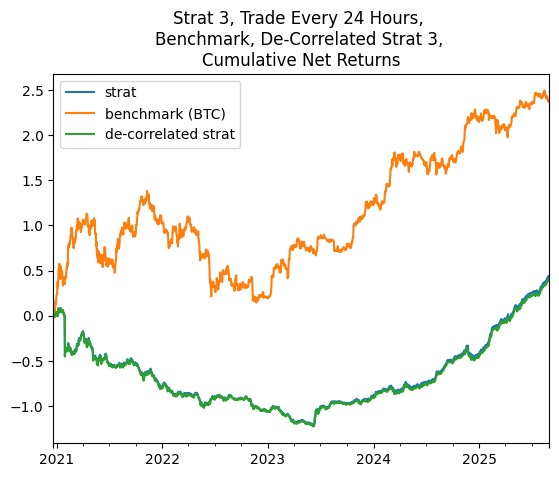

In [35]:
btc_rets = px_24h['BTCUSDT'] / px_24h['BTCUSDT'].shift() - 1

df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": btc_rets,
    "de-correlated strat": get_decorrelated_returns(net_returns, btc_rets)
})

df.cumsum().plot(title = "Strat 3, Trade Every 24 Hours, \nBenchmark, De-Correlated Strat 3, \nCumulative Net Returns")

# Strategy 14: Strategy 3 with winsorization

In [74]:
raw_signal = pd.read_csv('./rolling_corr_signal_window_20.csv', index_col = 0)
raw_signal.index = raw_signal.index.map(lambda t: datetime.strptime(t, "%Y-%m-%d %H:%M:%S"))

# Prepend nan data for first 20 periods not included
data_to_prepend = dict()

for index in px[px.index < raw_signal.index[0]].index:
    data_to_prepend[index] = pd.Series(index=px.columns)

raw_signal = pd.concat([pd.DataFrame(data_to_prepend).T, raw_signal])

## Winsorize Top And Bottom 10%, 4 Hours

<Axes: title={'center': 'Strat 14, Top And Bottom 10%, Cumulative Gross Returns'}>

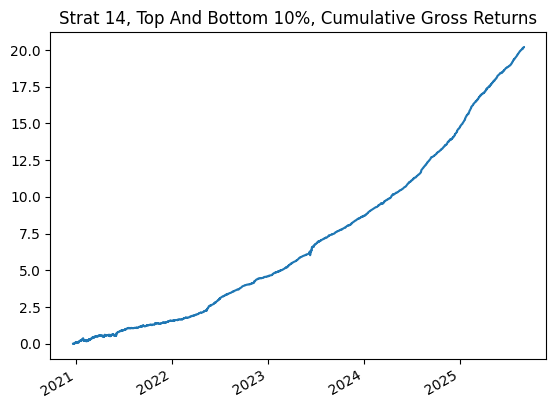

In [75]:
winsorized_signal = get_winsorized_signal(raw_signal, 0.1, 0.1)
transformed_signal = get_rank_demeaned_normalized_signal(winsorized_signal)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)

gross_returns.cumsum().plot(title="Strat 14, Top And Bottom 10%, Cumulative Gross Returns")

In [76]:
pd.Series(get_strategy_stats(net_returns, 4, px), name="Strat 14, Top And Bottom 10%").to_frame()

,"Strat 14, Top And Bottom 10%"
avg returns,-1.447833
decorrelated avg returns,-1.445469
volatility,0.265073
sharpe ratio,-5.462010
decorrelated sharpe ratio,-5.453172
max drawdown,-979.604484
max drawdown duration,1710.833333
alpha_BTC,-0.000660
beta_BTC,-0.004906


<Axes: >

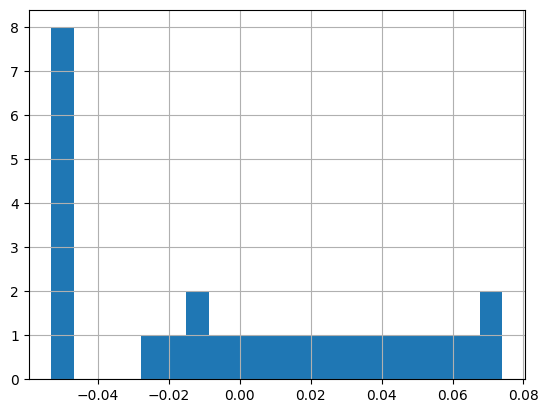

In [77]:
transformed_signal.iloc[1000].hist(bins=20)

<Axes: title={'center': 'Strat 14, Top And Bottom 10%, Benchmark, \nDe-Correlated Strat 14, Cumulative Net Returns'}>

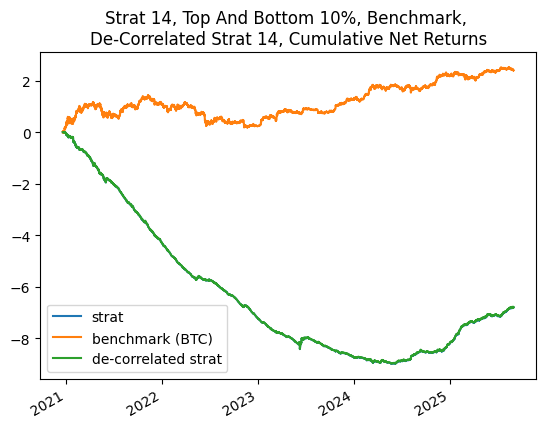

In [78]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 14, Top And Bottom 10%, Benchmark, \nDe-Correlated Strat 14, Cumulative Net Returns")

## Winsorize Top And Bottom 20%, 4 Hours

<Axes: title={'center': 'Strat 14, Top And Bottom 20%, Cumulative Gross Returns'}>

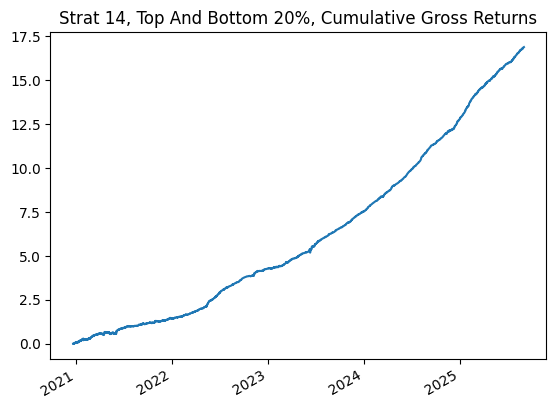

In [79]:
winsorized_signal = get_winsorized_signal(raw_signal, 0.2, 0.2)
transformed_signal = get_rank_demeaned_normalized_signal(winsorized_signal)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)

gross_returns.cumsum().plot(title="Strat 14, Top And Bottom 20%, Cumulative Gross Returns")

In [80]:
pd.Series(get_strategy_stats(net_returns, 4, px), name="Strat 14, Top And Bottom 20%").to_frame()

,"Strat 14, Top And Bottom 20%"
avg returns,-1.403263
decorrelated avg returns,-1.374119
volatility,0.237647
sharpe ratio,-5.904832
decorrelated sharpe ratio,-5.844827
max drawdown,-887.107806
max drawdown duration,1710.833333
alpha_BTC,-0.000628
beta_BTC,-0.057297


<Axes: >

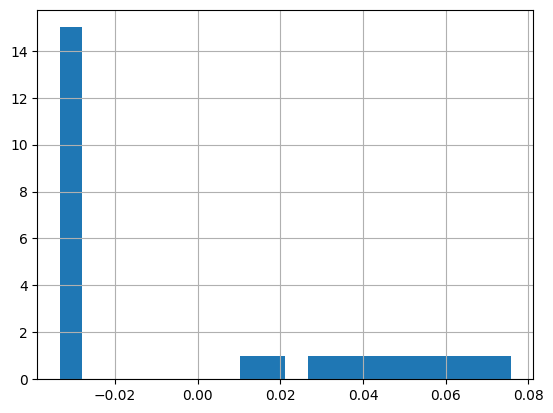

In [81]:
transformed_signal.iloc[1000].hist(bins=20)

<Axes: title={'center': 'Strat 14, Top And Bottom 20%, Benchmark, \nDe-Correlated Strat 14, Cumulative Net Returns'}>

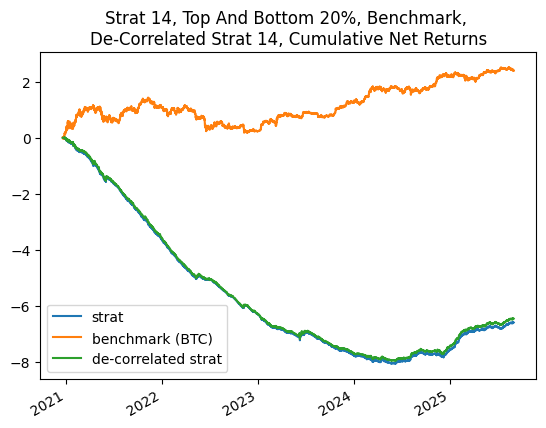

In [82]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 14, Top And Bottom 20%, Benchmark, \nDe-Correlated Strat 14, Cumulative Net Returns")

## Winsorize Top And Bottom 30%, 4 Hours

<Axes: title={'center': 'Strat 14, Top And Bottom 30%, Cumulative Gross Returns'}>

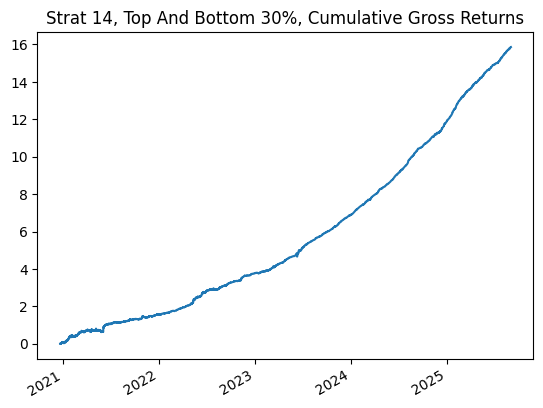

In [83]:
winsorized_signal = get_winsorized_signal(raw_signal, 0.3, 0.3)
transformed_signal = get_rank_demeaned_normalized_signal(winsorized_signal)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)

gross_returns.cumsum().plot(title="Strat 14, Top And Bottom 30%, Cumulative Gross Returns")

In [84]:
pd.Series(get_strategy_stats(net_returns, 4, px), name="Strat 14, Top And Bottom 30%").to_frame()

,"Strat 14, Top And Bottom 30%"
avg returns,-1.200369
decorrelated avg returns,-1.148783
volatility,0.276802
sharpe ratio,-4.336561
decorrelated sharpe ratio,-4.256028
max drawdown,-226.830984
max drawdown duration,1708.000000
alpha_BTC,-0.000525
beta_BTC,-0.101169


<Axes: >

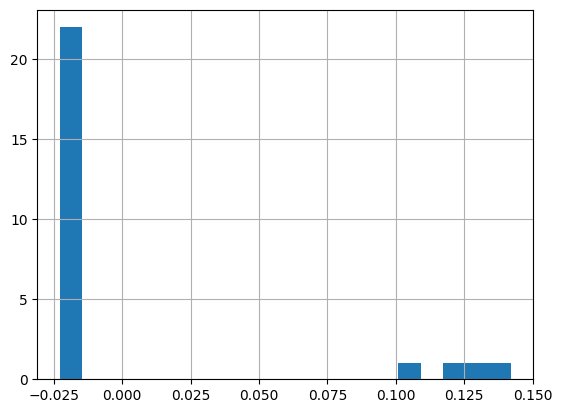

In [85]:
transformed_signal.iloc[1000].hist(bins=20)

<Axes: title={'center': 'Strat 14, Top And Bottom 30%, Benchmark, \nDe-Correlated Strat 14, Cumulative Net Returns'}>

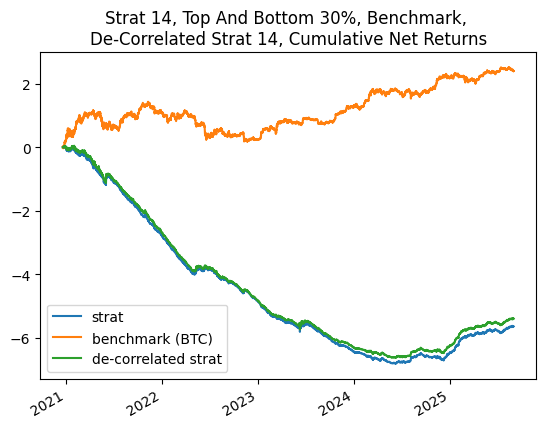

In [86]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 14, Top And Bottom 30%, Benchmark, \nDe-Correlated Strat 14, Cumulative Net Returns")

## Winsorize Top And Bottom 10%, Trade Once Per Day

Note: The signal continues to be calculated once every 4 hours but we only make changes to holdings at the beginning of each day.

<Axes: title={'center': 'Strat 14, Top And Bottom 10%, Traded Daily, \nCumulative Gross Returns'}>

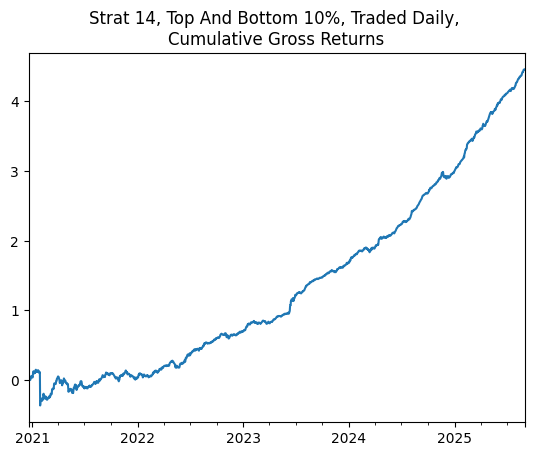

In [87]:
raw_1d_signal = raw_signal[raw_signal.index.hour == 0]
px_1d = px[px.index.hour == 0]

winsorized_signal = get_winsorized_signal(raw_1d_signal, 0.1, 0.1)
transformed_signal = get_rank_demeaned_normalized_signal(winsorized_signal)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px_1d)

gross_returns.cumsum().plot(title="Strat 14, Top And Bottom 10%, Traded Daily, \nCumulative Gross Returns")

In [88]:
pd.Series(get_strategy_stats(net_returns, 24, px_1d), name="Strat 14, Top And Bottom 10%, Traded Daily").to_frame()

,"Strat 14, Top And Bottom 10%, Traded Daily"
avg returns,0.037160
decorrelated avg returns,0.042343
volatility,0.299574
sharpe ratio,0.124044
decorrelated sharpe ratio,0.141330
max drawdown,-15.759880
max drawdown duration,1667.000000
alpha_BTC,0.000116
beta_BTC,-0.010212


<Axes: title={'center': 'Strat 14, Top And Bottom 10%, Traded Daily, Benchmark, \nDe-Correlated Strat 14, Cumulative Net Returns'}>

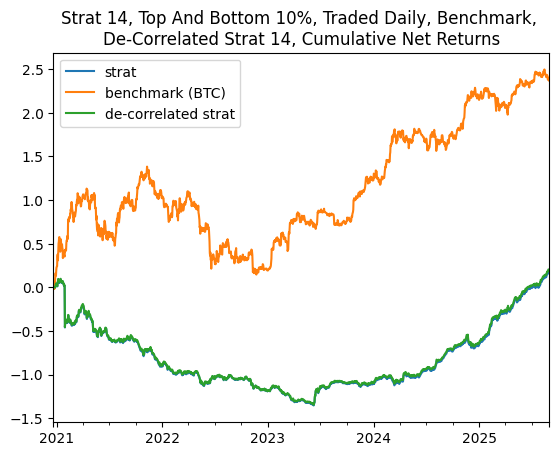

In [89]:
bitcoin_1d_benchmark_returns = px_1d['BTCUSDT'] / px_1d['BTCUSDT'].shift() - 1

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_1d_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_1d_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 14, Top And Bottom 10%, Traded Daily, Benchmark, \nDe-Correlated Strat 14, Cumulative Net Returns")

## Winsorize Top And Bottom 20%, Trade Once Per Day

<Axes: title={'center': 'Strat 14, Top And Bottom 20%, Traded Daily, \nCumulative Gross Returns'}>

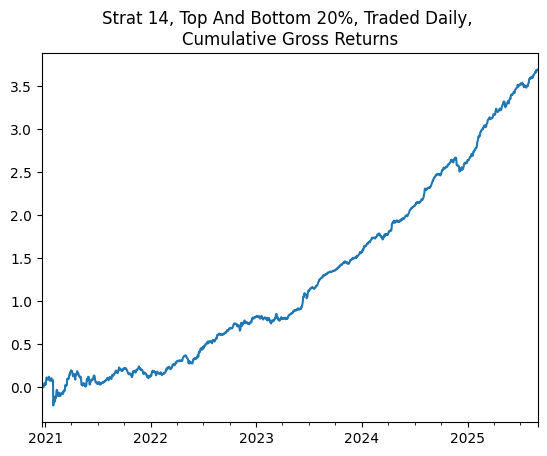

In [90]:
raw_1d_signal = raw_signal[raw_signal.index.hour == 0]
px_1d = px[px.index.hour == 0]

winsorized_signal = get_winsorized_signal(raw_1d_signal, 0.2, 0.2)
transformed_signal = get_rank_demeaned_normalized_signal(winsorized_signal)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px_1d)

gross_returns.cumsum().plot(title="Strat 14, Top And Bottom 20%, Traded Daily, \nCumulative Gross Returns")

In [91]:
pd.Series(get_strategy_stats(net_returns, 24, px_1d), name="Strat 14, Top And Bottom 20%, Traded Daily").to_frame()

,"Strat 14, Top And Bottom 20%, Traded Daily"
avg returns,-0.004906
decorrelated avg returns,0.029665
volatility,0.242273
sharpe ratio,-0.020251
decorrelated sharpe ratio,0.124182
max drawdown,-13.771170
max drawdown duration,1698.000000
alpha_BTC,0.000080
beta_BTC,-0.068428


<Axes: title={'center': 'Strat 14, Top And Bottom 20%, Traded Daily, Benchmark, \nDe-Correlated Strat 14, Cumulative Net Returns'}>

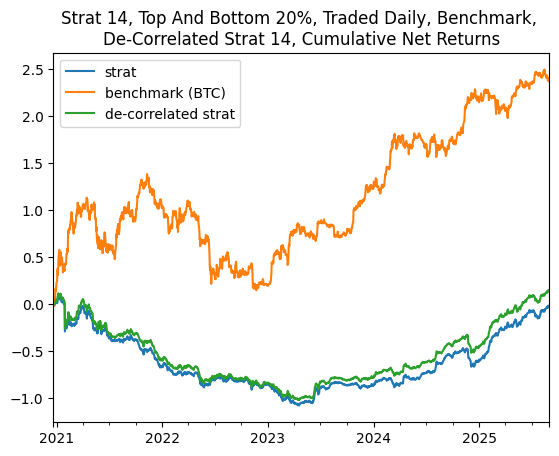

In [92]:
bitcoin_1d_benchmark_returns = px_1d['BTCUSDT'] / px_1d['BTCUSDT'].shift() - 1

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_1d_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_1d_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 14, Top And Bottom 20%, Traded Daily, Benchmark, \nDe-Correlated Strat 14, Cumulative Net Returns")

# Strategy 15: Strategy 3 with truncation

In [93]:
raw_signal = pd.read_csv('./rolling_corr_signal_window_20.csv', index_col = 0)
raw_signal.index = raw_signal.index.map(lambda t: datetime.strptime(t, "%Y-%m-%d %H:%M:%S"))

# Prepend nan data for first 20 periods not included
data_to_prepend = dict()

for index in px[px.index < raw_signal.index[0]].index:
    data_to_prepend[index] = pd.Series(index=px.columns)

raw_signal = pd.concat([pd.DataFrame(data_to_prepend).T, raw_signal])

## Truncate top and bottom 10%

<Axes: title={'center': 'Strat 15, Top And Bottom 10%, Cumulative Gross Returns'}>

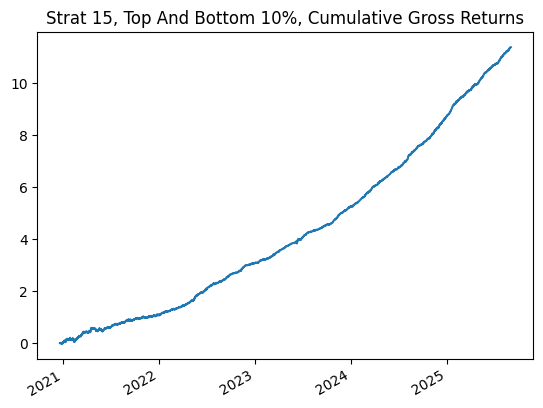

In [94]:
truncated_signal = get_truncated_signal(raw_signal, 0.1, 0.1)
transformed_signal = get_rank_demeaned_normalized_signal(truncated_signal)

gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
gross_returns.cumsum().plot(title="Strat 15, Top And Bottom 10%, Cumulative Gross Returns")

In [95]:
pd.Series(get_strategy_stats(net_returns, 4, px), name="Strat 15, Top And Bottom 10%").to_frame()

,"Strat 15, Top And Bottom 10%"
avg returns,-4.093502
decorrelated avg returns,-4.101334
volatility,0.197101
sharpe ratio,-20.768549
decorrelated sharpe ratio,-20.828374
max drawdown,-12561.384796
max drawdown duration,1711.333333
alpha_BTC,-0.001873
beta_BTC,0.014534


<Axes: >

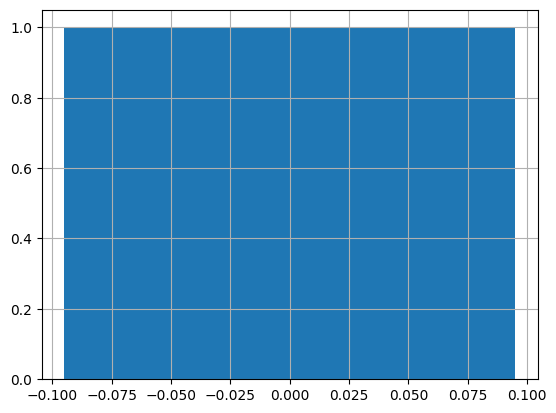

In [96]:
transformed_signal.iloc[1000].hist(bins=20)

<Axes: title={'center': 'Strat 15, Top And Bottom 10%, Benchmark, \nDe-Correlated Strat 15, Cumulative Net Returns'}>

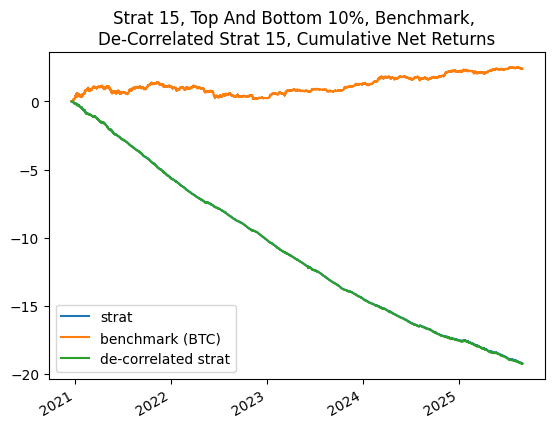

In [97]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 15, Top And Bottom 10%, Benchmark, \nDe-Correlated Strat 15, Cumulative Net Returns")

## Truncate top and bottom 20%

<Axes: title={'center': 'Strat 15, Top And Bottom 20%, Cumulative Gross Returns'}>

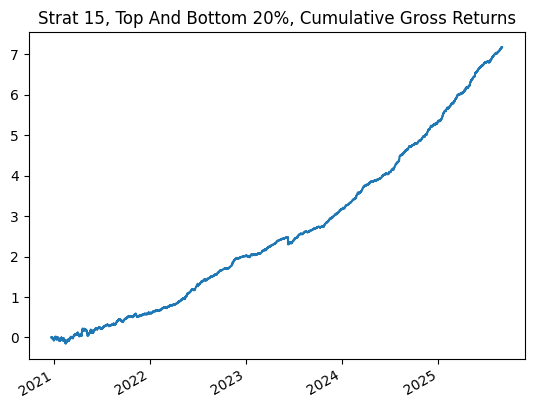

In [98]:
truncated_signal = get_truncated_signal(raw_signal, 0.2, 0.2)
transformed_signal = get_rank_demeaned_normalized_signal(truncated_signal)

gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
gross_returns.cumsum().plot(title="Strat 15, Top And Bottom 20%, Cumulative Gross Returns")

In [99]:
pd.Series(get_strategy_stats(net_returns, 4, px), name="Strat 15, Top And Bottom 20%").to_frame()

,"Strat 15, Top And Bottom 20%"
avg returns,-5.426297
decorrelated avg returns,-5.430350
volatility,0.210951
sharpe ratio,-25.723037
decorrelated sharpe ratio,-25.746450
max drawdown,-5708.176344
max drawdown duration,1711.333333
alpha_BTC,-0.002480
beta_BTC,0.006884


<Axes: >

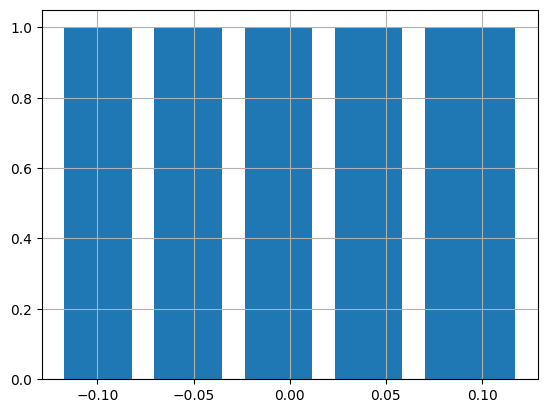

In [100]:
transformed_signal.iloc[1000].hist(bins=20)

<Axes: title={'center': 'Strat 15, Top And Bottom 20%, Benchmark, \nDe-Correlated Strat 15, Cumulative Net Returns'}>

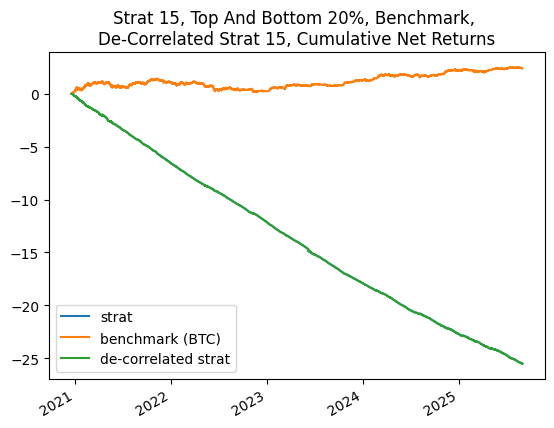

In [101]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 15, Top And Bottom 20%, Benchmark, \nDe-Correlated Strat 15, Cumulative Net Returns")

## Truncate Top And Bottom 10%, Trade Daily With 4-hour Signal

<Axes: title={'center': 'Strat 15, Top And Bottom 10%, Trade Daily, Cumulative Gross Returns'}>

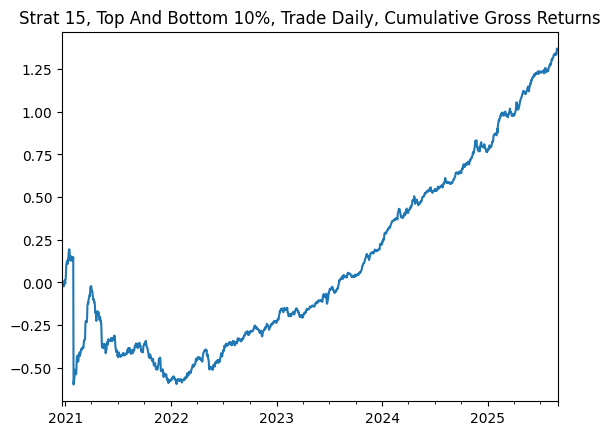

In [102]:
raw_signal_1d = raw_signal[raw_signal.index.hour == 0]
px_1d = px[px.index.hour == 0]

truncated_signal = get_truncated_signal(raw_signal_1d, 0.1, 0.1)
transformed_signal = get_rank_demeaned_normalized_signal(truncated_signal)

gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px_1d)
gross_returns.cumsum().plot(title="Strat 15, Top And Bottom 10%, Trade Daily, Cumulative Gross Returns")

In [103]:
pd.Series(get_strategy_stats(net_returns, 24, px_1d), name="Strat 15, Top And Bottom 10%, Traded Daily").to_frame()

,"Strat 15, Top And Bottom 10%, Traded Daily"
avg returns,-0.769965
decorrelated avg returns,-0.765923
volatility,0.390105
sharpe ratio,-1.973736
decorrelated sharpe ratio,-1.962988
max drawdown,-29.053229
max drawdown duration,1690.000000
alpha_BTC,-0.002100
beta_BTC,-0.008920


<Axes: >

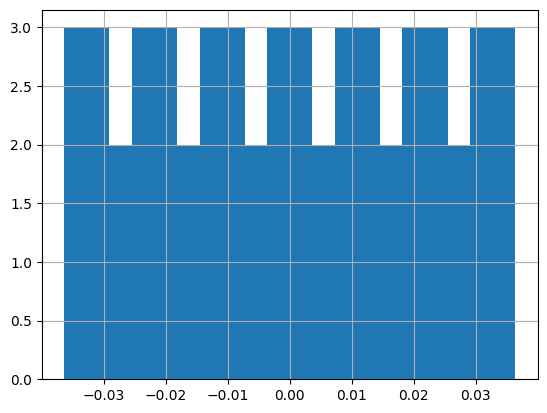

In [104]:
transformed_signal.iloc[1000].hist(bins=20)

<Axes: title={'center': 'Strat 15, Top And Bottom 10%, Traded Daily, Benchmark, \nDe-Correlated Strat 15, Cumulative Net Returns'}>

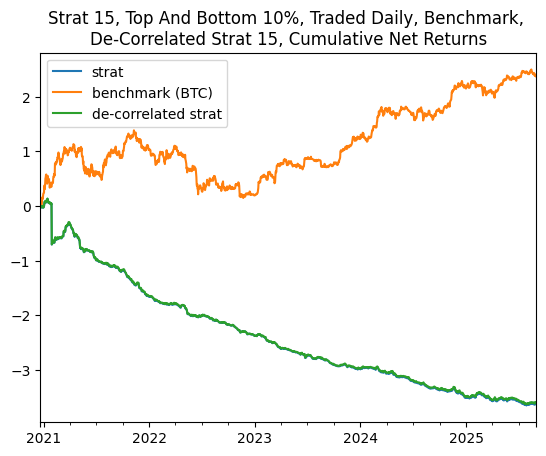

In [105]:
bitcoin_1d_benchmark_returns = px_1d['BTCUSDT'] / px_1d['BTCUSDT'].shift() - 1

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_1d_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_1d_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 15, Top And Bottom 10%, Traded Daily, Benchmark, \nDe-Correlated Strat 15, Cumulative Net Returns")

# Strategy 16: Strategy 3 with rank-thresholding

In [125]:
raw_signal = pd.read_csv('./rolling_corr_signal_window_20.csv', index_col = 0)
raw_signal.index = raw_signal.index.map(lambda t: datetime.strptime(t, "%Y-%m-%d %H:%M:%S"))

# Prepend nan data for first 20 periods not included
data_to_prepend = dict()

for index in px[px.index < raw_signal.index[0]].index:
    data_to_prepend[index] = pd.Series(index=px.columns)

raw_signal = pd.concat([pd.DataFrame(data_to_prepend).T, raw_signal])

## Rank-threshold top and bottom 5%

<Axes: title={'center': 'Strat 16, Top And Bottom 5%, Cumulative Gross Returns'}>

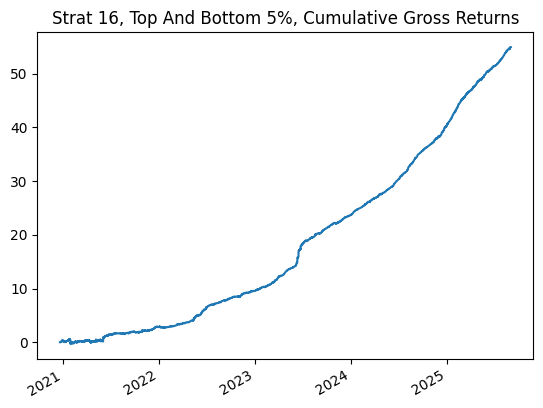

In [126]:
rank_threshold_signal = get_rank_thresholded_signal(raw_signal, 0.05, 0.05)
transformed_signal = get_rank_demeaned_normalized_signal(rank_threshold_signal)

gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
gross_returns.cumsum().plot(title="Strat 16, Top And Bottom 5%, Cumulative Gross Returns")

In [127]:
pd.Series(get_strategy_stats(net_returns, 4, px), name="Strat 16, Top And Bottom 5%").to_frame()

,"Strat 16, Top And Bottom 5%"
avg returns,3.731177
decorrelated avg returns,3.724394
volatility,1.103112
sharpe ratio,3.382409
decorrelated sharpe ratio,3.376197
max drawdown,-26.659684
max drawdown duration,1112.333333
alpha_BTC,0.001701
beta_BTC,0.013991


<Axes: title={'center': 'Strat 16, Top And Bottom 10%, Benchmark, \nDe-Correlated Strat 16, Cumulative Net Returns'}>

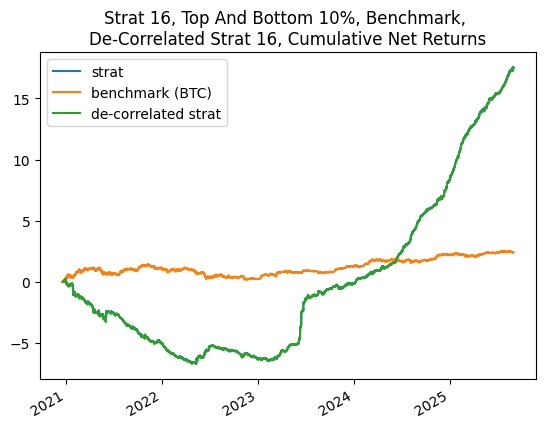

In [128]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 16, Top And Bottom 10%, Benchmark, \nDe-Correlated Strat 16, Cumulative Net Returns")

## Rank-threshold top and bottom 10%

<Axes: title={'center': 'Strat 16, Top And Bottom 10%, Cumulative Gross Returns'}>

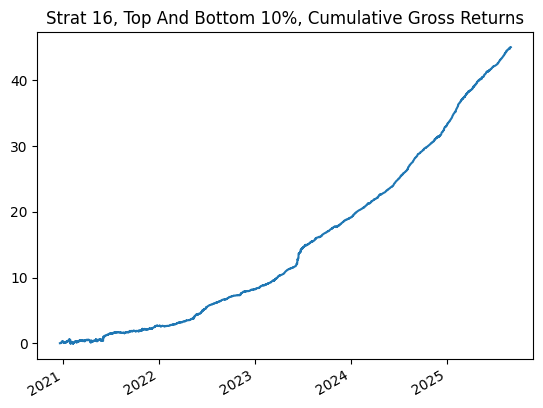

In [119]:
rank_threshold_signal = get_rank_thresholded_signal(raw_signal, 0.1, 0.1)
transformed_signal = get_rank_demeaned_normalized_signal(rank_threshold_signal)

gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
gross_returns.cumsum().plot(title="Strat 16, Top And Bottom 10%, Cumulative Gross Returns")

In [120]:
pd.Series(get_strategy_stats(net_returns, 4, px), name="Strat 16, Top And Bottom 10%").to_frame()

,"Strat 16, Top And Bottom 10%"
avg returns,1.828985
decorrelated avg returns,1.823202
volatility,0.760387
sharpe ratio,2.405333
decorrelated sharpe ratio,2.397716
max drawdown,-40.448959
max drawdown duration,1373.333333
alpha_BTC,0.000833
beta_BTC,0.011668


<Axes: title={'center': 'Strat 16, Top And Bottom 10%, Benchmark, \nDe-Correlated Strat 16, Cumulative Net Returns'}>

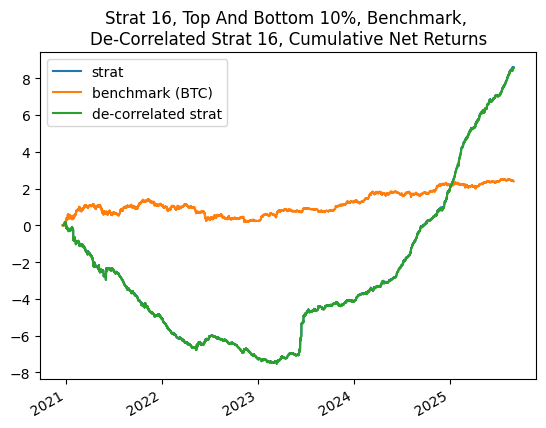

In [121]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 16, Top And Bottom 10%, Benchmark, \nDe-Correlated Strat 16, Cumulative Net Returns")

## Rank-threshold top and bottom 20%

<Axes: title={'center': 'Strat 16, Top And Bottom 20%, Cumulative Gross Returns'}>

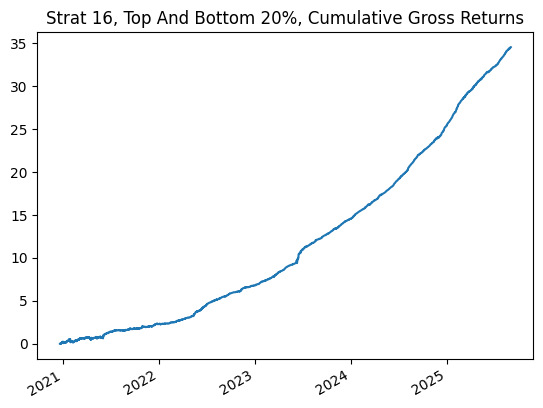

In [122]:
rank_threshold_signal = get_rank_thresholded_signal(raw_signal, 0.2, 0.2)
transformed_signal = get_rank_demeaned_normalized_signal(rank_threshold_signal)

gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px)
gross_returns.cumsum().plot(title="Strat 16, Top And Bottom 20%, Cumulative Gross Returns")

In [123]:
pd.Series(get_strategy_stats(net_returns, 4, px), name="Strat 16, Top And Bottom 20%").to_frame()

,"Strat 16, Top And Bottom 20%"
avg returns,6.810861e-03
decorrelated avg returns,-1.009444e-03
volatility,4.948434e-01
sharpe ratio,1.376367e-02
decorrelated sharpe ratio,-2.040186e-03
max drawdown,-8.864134e+01
max drawdown duration,1.704667e+03
alpha_BTC,-4.452703e-07
beta_BTC,1.530324e-02


<Axes: title={'center': 'Strat 16, Top And Bottom 20%, Benchmark, \nDe-Correlated Strat 16, Cumulative Net Returns'}>

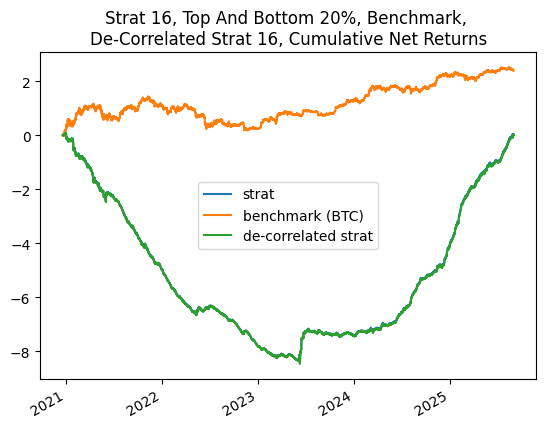

In [124]:
graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 16, Top And Bottom 20%, Benchmark, \nDe-Correlated Strat 16, Cumulative Net Returns")

## Rank-Threshold Top And Bottom 5%, Only Trade Daily

<Axes: title={'center': 'Strat 16, Top And Bottom 5%, Trade Only Daily, Cumulative Gross Returns'}>

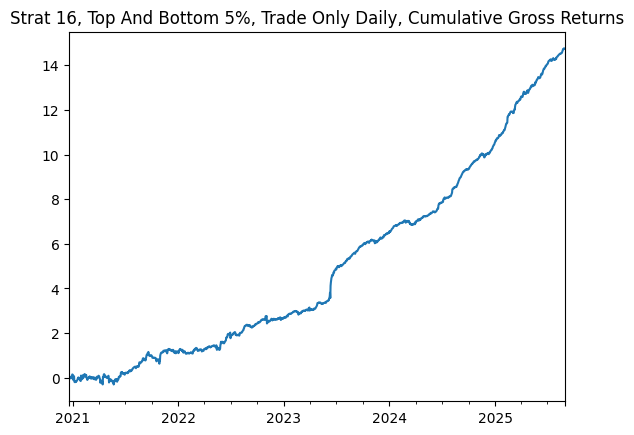

In [134]:
raw_signal_1d = raw_signal[raw_signal.index.hour == 0]
px_1d = px[px.index.hour == 0]

rank_threshold_signal = get_rank_thresholded_signal(raw_signal_1d, 0.05, 0.05)
transformed_signal = get_rank_demeaned_normalized_signal(rank_threshold_signal)

gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, px_1d)
gross_returns.cumsum().plot(title="Strat 16, Top And Bottom 5%, Trade Only Daily, Cumulative Gross Returns")

In [135]:
pd.Series(get_strategy_stats(net_returns, 24, px_1d), name="Strat 16, Top And Bottom 5%, Trade Only Daily").to_frame()

,"Strat 16, Top And Bottom 5%, Trade Only Daily"
avg returns,1.821450
decorrelated avg returns,1.802246
volatility,0.746165
sharpe ratio,2.441081
decorrelated sharpe ratio,2.415891
max drawdown,-9.958535
max drawdown duration,338.000000
alpha_BTC,0.004941
beta_BTC,0.040181


<Axes: title={'center': 'Strat 16, Top And Bottom 5%, Trade Only Daily, Benchmark, \nDe-Correlated Strat 16, Cumulative Net Returns'}>

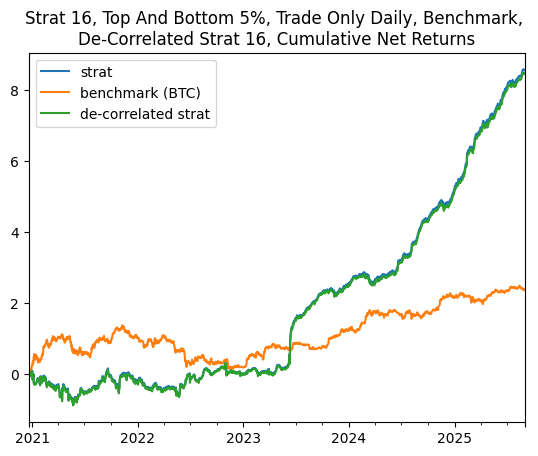

In [137]:
bitcoin_1d_benchmark_returns = px_1d['BTCUSDT'] / px_1d['BTCUSDT'].shift() - 1

graph_df = pd.DataFrame({
    "strat": net_returns,
    "benchmark (BTC)": bitcoin_1d_benchmark_returns,
    "de-correlated strat": get_decorrelated_returns(net_returns, bitcoin_1d_benchmark_returns)
})

graph_df.cumsum().plot(title = "Strat 16, Top And Bottom 5%, Trade Only Daily, Benchmark, \nDe-Correlated Strat 16, Cumulative Net Returns")